In [12]:
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
import sklearn.tree as tree
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from itertools import combinations
import numpy as np

## Load dataset

In [2]:
adult = fetch_ucirepo(id=2)
X_original = adult.data.features
y_original = adult.data.targets
print(X_original)
print(y_original)

       age         workclass  fnlwgt  education  education-num  \
0       39         State-gov   77516  Bachelors             13   
1       50  Self-emp-not-inc   83311  Bachelors             13   
2       38           Private  215646    HS-grad              9   
3       53           Private  234721       11th              7   
4       28           Private  338409  Bachelors             13   
...    ...               ...     ...        ...            ...   
48837   39           Private  215419  Bachelors             13   
48838   64               NaN  321403    HS-grad              9   
48839   38           Private  374983  Bachelors             13   
48840   44           Private   83891  Bachelors             13   
48841   35      Self-emp-inc  182148  Bachelors             13   

           marital-status         occupation    relationship  \
0           Never-married       Adm-clerical   Not-in-family   
1      Married-civ-spouse    Exec-managerial         Husband   
2              

## Data preparation

In [3]:
X_age = np.array(X_original)[:20000,0]
X_wh = np.array(X_original)[:20000,12]
X = np.column_stack((X_age, X_wh))
print(X)
y = np.array(y_original)[:20000]
y_cleaned = np.array([label[0].replace('.', '') for label in y])
encoder = LabelEncoder()
y = encoder.fit_transform(y_cleaned)
print(y)

[[39 40]
 [50 13]
 [38 40]
 ...
 [72 99]
 [54 44]
 [30 40]]
[0 0 0 ... 0 1 1]


## Data normalization

In [4]:
X = pd.DataFrame(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = 2*y - 1
print(X_scaled)
print(y)

[[ 0.02961142 -0.03230868]
 [ 0.83476689 -2.23128626]
 [-0.04358453 -0.03230868]
 ...
 [ 2.44507783  4.77286455]
 [ 1.1275507   0.29346577]
 [-0.62915214 -0.03230868]]
[-1 -1 -1 ... -1  1  1]


## Preparing selected features

In [5]:
X_age = np.array(X_original)[:20000,0]  # age
X_edu = np.array(X_original)[:20000,4]  # education-num
X_sex = np.array(X_original)[:20000,9]  # sex
X_hours = np.array(X_original)[:20000,12]  # hours-per-week
X_marital = np.array(X_original)[:20000,5]  # marital-status
X_selected = np.column_stack((X_age, X_edu, X_sex, X_hours, X_marital))
X_selected = pd.DataFrame(X_selected, columns=['age', 'education-num', 'sex', 'hours-per-week', 'marital-status'])

# Encode categorical variables
label_encoder = LabelEncoder()
X_selected['sex'] = label_encoder.fit_transform(X_selected['sex'])
X_selected['marital-status'] = label_encoder.fit_transform(X_selected['marital-status'])

# Scale the features
scaler = StandardScaler()
X_selected_scaled = scaler.fit_transform(X_selected)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_selected_scaled, y, test_size=0.3, random_state=42)


## Part 1: Linear Regression


Linear Regression Results:
Coefficients: [ 0.15150536  0.2488241   0.13063162  0.10788532 -0.07952674]
Intercept: -0.5233440244189612
Score: 0.21678827079590157


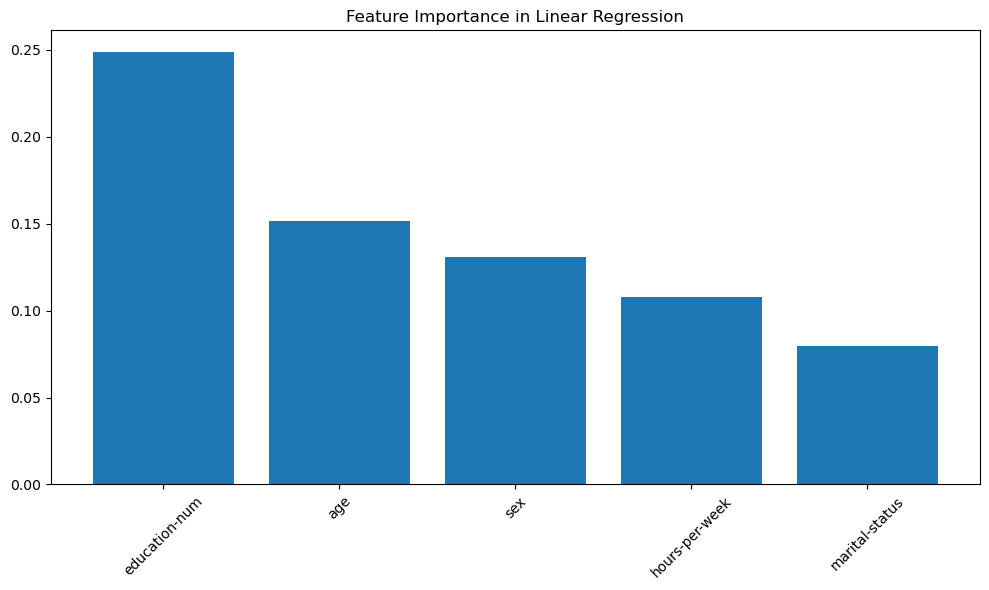

In [34]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
print("\nLinear Regression Results:")
print("Coefficients:", lr_model.coef_)
print("Intercept:", lr_model.intercept_)
print("Score:", lr_model.score(X_test, y_test))

plt.figure(figsize=(10, 6))
feature_importance = pd.DataFrame({
    'feature': ['age', 'education-num', 'sex', 'hours-per-week', 'marital-status'],
    'importance': abs(lr_model.coef_)
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.xticks(rotation=45)
plt.title('Feature Importance in Linear Regression')
plt.tight_layout()
plt.show()


### From the bar chart we can know the relative impact of each feature on income prediction in our linear regression model:
Education-num > Age > Sex > Hours-per-week > Marital-status

#### MSE Analysis

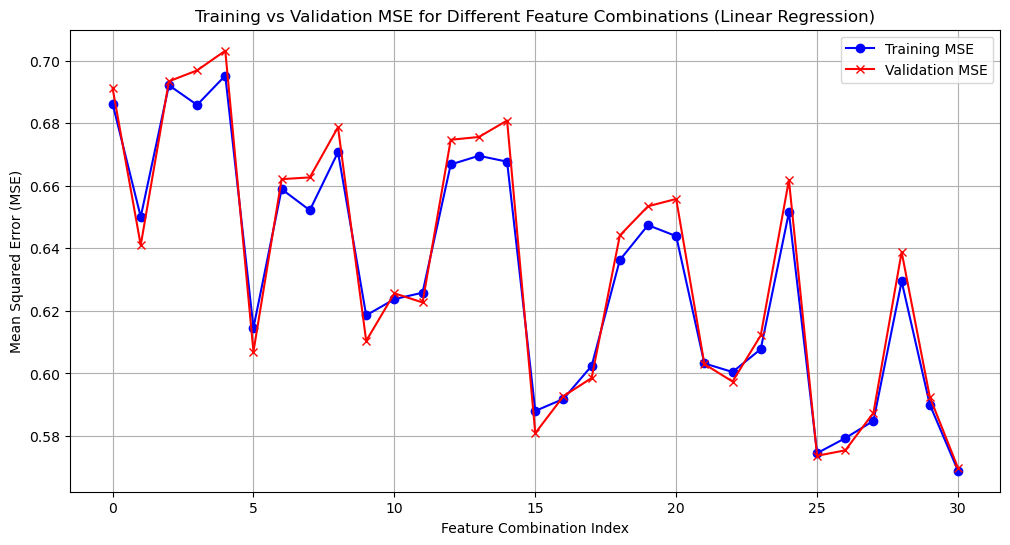

Validation MSE: 0.5698


In [15]:
feature_combinations = []
all_features = ['age', 'education-num', 'sex', 'hours-per-week', 'marital-status']
for r in range(1, len(all_features) + 1):
    feature_combinations.extend(combinations(range(X_selected_scaled.shape[1]), r))

results_lr = []

for combo in feature_combinations:
    X_train_combo = X_train[:, list(combo)]
    X_test_combo = X_test[:, list(combo)]
    
    lr = LinearRegression()
    lr.fit(X_train_combo, y_train)
    
    y_train_pred = lr.predict(X_train_combo)
    y_val_pred = lr.predict(X_test_combo)
    
    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_test, y_val_pred)
    
    results_lr.append({
        'features': [all_features[i] for i in combo],
        'train_mse': train_mse,
        'val_mse': val_mse
    })

# Convert results to DataFrame
results_lr_df = pd.DataFrame(results_lr)

# Plot Linear Regression results
plt.figure(figsize=(12, 6))
plt.plot(range(len(results_lr_df)), results_lr_df['train_mse'], 
         color='blue', label='Training MSE', marker='o')
plt.plot(range(len(results_lr_df)), results_lr_df['val_mse'], 
         color='red', label='Validation MSE', marker='x')

plt.legend()
plt.xlabel("Feature Combination Index")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Training vs Validation MSE for Different Feature Combinations (Linear Regression)")
plt.grid(True)
plt.show()

# Find best feature combination for Linear Regression
best_lr_idx = results_lr_df['val_mse'].idxmin()
best_lr_combo = results_lr_df.iloc[best_lr_idx]
print(f"Validation MSE: {best_lr_combo['val_mse']:.4f}")

## Part 2: KNN Classification


KNN Classification Results:
Accuracy: 0.8151666666666667

Classification Report:
              precision    recall  f1-score   support

          -1       0.87      0.90      0.88      4566
           1       0.63      0.56      0.59      1434

    accuracy                           0.82      6000
   macro avg       0.75      0.73      0.74      6000
weighted avg       0.81      0.82      0.81      6000



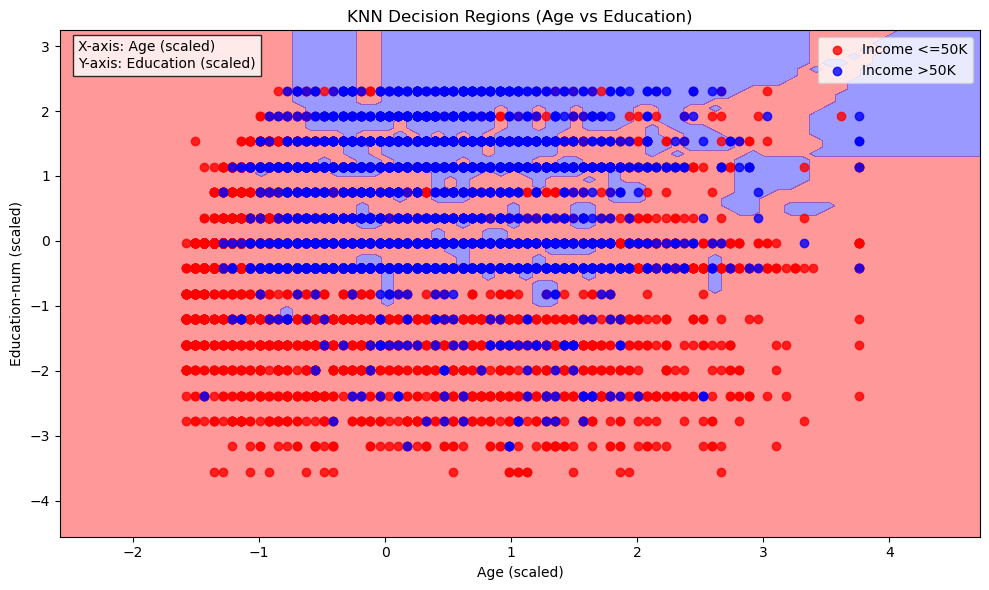

In [9]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)

print("\nKNN Classification Results:")
print("Accuracy:", accuracy_score(y_test, knn_pred))
print("\nClassification Report:")
print(classification_report(y_test, knn_pred))

plt.figure(figsize=(10, 6))
X_subset = X_selected_scaled[:, [0, 1]]  
X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X_subset, y, test_size=0.3, random_state=42)

knn_subset = KNeighborsClassifier(n_neighbors=5)
knn_subset.fit(X_train_subset, y_train_subset)

x_min, x_max = X_subset[:, 0].min() - 1, X_subset[:, 0].max() + 1
y_min, y_max = X_subset[:, 1].min() - 1, X_subset[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = knn_subset.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Create contour plot with distinct colors
plt.contourf(xx, yy, Z, alpha=0.4, levels=[-2,0,2], colors=['red', 'blue'])

# Create scatter plot with distinct colors for each class
mask_low = y_train_subset == -1
mask_high = y_train_subset == 1

plt.scatter(X_train_subset[mask_low, 0], X_train_subset[mask_low, 1], 
           c='red', label='Income <=50K', alpha=0.8)
plt.scatter(X_train_subset[mask_high, 0], X_train_subset[mask_high, 1], 
           c='blue', label='Income >50K', alpha=0.8)

plt.xlabel('Age (scaled)')
plt.ylabel('Education-num (scaled)')
plt.title('KNN Decision Regions (Age vs Education)')

# Add legend
plt.legend()

# Add text to explain the axes
plt.text(0.02, 0.98, 'X-axis: Age (scaled)\nY-axis: Education (scaled)', 
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8),
         verticalalignment='top')

plt.tight_layout()
plt.show()

#### From diagram we can know:
Higher education levels tend to show more blue regions (higher income)
Middle-aged individuals with higher education show strongest concentration of high income
Lower education levels predominantly show red regions (lower income)

### MSE analysis

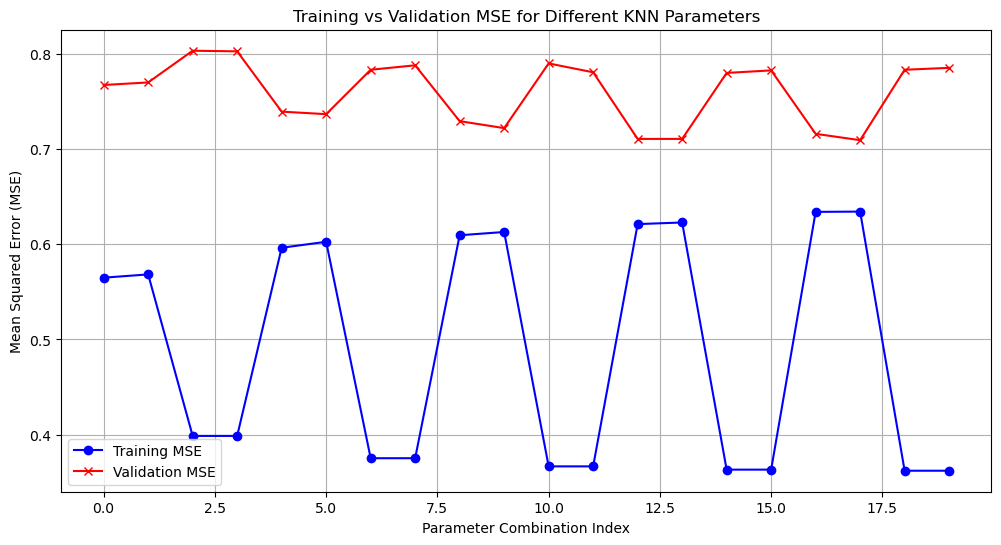

Validation MSE: 0.7093


In [14]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

results_knn = []

# Try different combinations of parameters
for n_neighbors in param_grid_knn['n_neighbors']:
    for weights in param_grid_knn['weights']:
        for metric in param_grid_knn['metric']:
            knn = KNeighborsClassifier(
                n_neighbors=n_neighbors,
                weights=weights,
                metric=metric
            )
            
            knn.fit(X_train, y_train)
            
            y_train_pred = knn.predict(X_train)
            y_val_pred = knn.predict(X_test)
            
            train_mse = mean_squared_error(y_train, y_train_pred)
            val_mse = mean_squared_error(y_test, y_val_pred)
            
            results_knn.append({
                'n_neighbors': n_neighbors,
                'weights': weights,
                'metric': metric,
                'train_mse': train_mse,
                'val_mse': val_mse
            })

# Convert results to DataFrame
results_knn_df = pd.DataFrame(results_knn)

# Plot KNN results
plt.figure(figsize=(12, 6))
plt.plot(range(len(results_knn_df)), results_knn_df['train_mse'], 
         color='blue', label='Training MSE', marker='o')
plt.plot(range(len(results_knn_df)), results_knn_df['val_mse'], 
         color='red', label='Validation MSE', marker='x')

plt.legend()
plt.xlabel("Parameter Combination Index")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Training vs Validation MSE for Different KNN Parameters")
plt.grid(True)
plt.show()

# Find best KNN parameters
best_knn_idx = results_knn_df['val_mse'].idxmin()
best_knn_params = results_knn_df.iloc[best_knn_idx]
print(f"Validation MSE: {best_knn_params['val_mse']:.4f}")

## Conclusion

Linear Regression MSE: 0.5698 performed better than KNN MSE: 0.7093.
This suggests the relationship between features and income might be more linear in nature